# 4) Phrase Diversity (n-gram TTR)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Measure phrase diversity using Type-Token Ratio (TTR) for bigrams and trigrams.
- Compare lexical variety across two works by the same author.
- (Optional) Analyze diversity trends across sections/chapters within the texts.

Learning objectives:
- Understand and compute Type-Token Ratio (TTR) as a measure of lexical/phrasal diversity.
- Apply TTR to n-grams (bigrams, trigrams) to quantify phrase variety.
- Interpret TTR values: lower TTR suggests formulaic/repetitive phrasing, higher TTR indicates more varied expression.
- Produce reproducible diversity metrics and visualizations for literary analysis.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. (Optional) Toggle `use_stopwords` to exclude common function words.
3. Run cells from top to bottom. The main outputs are saved to `../results/`.
4. (Optional) Customize section-splitting regex to analyze diversity by chapter.

Prerequisites:
- A Python environment with requirements.txt packages installed (pandas, matplotlib).
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook uses the same robust preprocessing as notebooks 1-2 (strip_gutenberg, normalize quotes, etc.).
- TTR formula: (unique n-grams) / (total n-grams). Values range from 0 to 1.
- Lower TTR: more repetition (e.g., epic poetry with formulaic epithets like "wine-dark sea").
- Higher TTR: more varied phrasing (e.g., experimental modernist prose).
- Section-wise analysis (optional cell) helps identify where diversity changes within a work.
- Compare TTR between your two books to see if the author's style evolved or differs by genre.
- Stopword removal may artificially inflate TTR by reducing common bigrams like "of the" or "in the".

**Goal:** Apply Type-Token Ratio (TTR) to bigrams and trigrams to measure phrase diversity in your two selected works.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [1]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "../data/PetSemetary.txt",   # Pet Sematary
    "book2_path": "../data/TheShining.txt",    # The Shining
    "language": "en",
    "use_stopwords": False,                    # you can toggle this
    "min_ngram_count": 5,
    "top_k": 20
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()


## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [2]:
def load_text(p: str) -> str:
    """Load text file as UTF-8, ignoring bad bytes."""
    return Path(p).read_text(encoding="utf-8", errors="ignore")

def normalize_text(t: str) -> str:
    """Simple normalization for local TXT files (not Gutenberg)."""
    if not t:
        return ""
    # normalize curly apostrophes to ASCII '
    t = t.replace("’", "'").replace("‘", "'")
    # join hyphenated line breaks (e.g., "won-\n derful" → "wonderful")
    t = re.sub(r"-\s*\n", "", t)
    # normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t.strip()

# Load + normalize
text1 = normalize_text(load_text(CONFIG["book1_path"]))  # Pet Sematary
text2 = normalize_text(load_text(CONFIG["book2_path"]))  # The Shining

# Tokenize
tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

# Optional stopwords
if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

# Optional: prune junk 1–2 letter tokens to match other notebooks
keep_1 = {"a", "i"}
keep_2 = {
    "of","to","in","on","by","an","or","as","is","it","we","us","he","me","my",
    "so","be","do","no","at","up","if","go","am","oh"
}

tokens1 = [
    t for t in tokens1
    if (len(t) > 2)
       or (len(t) == 1 and t in keep_1)
       or (len(t) == 2 and t in keep_2)
]
tokens2 = [
    t for t in tokens2
    if (len(t) > 2)
       or (len(t) == 1 and t in keep_1)
       or (len(t) == 2 and t in keep_2)
]

tokens = tokens1 + tokens2

print("Token counts after normalization + pruning:")
print("Pet Sematary:", len(tokens1))
print("The Shining :", len(tokens2))
print("Combined    :", len(tokens))

Token counts after normalization + pruning:
Pet Sematary: 145778
The Shining : 160457
Combined    : 306235


In [3]:
def load_text(p: str) -> str:
    """Load text file as UTF-8, ignoring bad bytes."""
    return Path(p).read_text(encoding="utf-8", errors="ignore")

def normalize_text(t: str) -> str:
    """Simple normalization for local TXT files (not Gutenberg)."""
    if not t:
        return ""
    # normalize curly apostrophes to ASCII '
    t = t.replace("’", "'").replace("‘", "'")
    # join hyphenated line breaks (e.g., "won-\n derful" → "wonderful")
    t = re.sub(r"-\s*\n", "", t)
    # normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t.strip()

# Load + normalize
text1 = normalize_text(load_text(CONFIG["book1_path"]))  # Pet Sematary
text2 = normalize_text(load_text(CONFIG["book2_path"]))  # The Shining

# Tokenize
tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

# Optional stopwords
if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

# Optional: prune junk 1–2 letter tokens to match other notebooks
keep_1 = {"a", "i"}
keep_2 = {
    "of","to","in","on","by","an","or","as","is","it","we","us","he","me","my",
    "so","be","do","no","at","up","if","go","am","oh"
}

tokens1 = [
    t for t in tokens1
    if (len(t) > 2)
       or (len(t) == 1 and t in keep_1)
       or (len(t) == 2 and t in keep_2)
]
tokens2 = [
    t for t in tokens2
    if (len(t) > 2)
       or (len(t) == 1 and t in keep_1)
       or (len(t) == 2 and t in keep_2)
]

tokens = tokens1 + tokens2

print("Token counts after normalization + pruning:")
print("Pet Sematary:", len(tokens1))
print("The Shining :", len(tokens2))
print("Combined    :", len(tokens))


Token counts after normalization + pruning:
Pet Sematary: 145778
The Shining : 160457
Combined    : 306235


## 2. Compute TTR for Bigrams & Trigrams

Type–Token Ratio for n-grams measures phrase variety.

$$\text{TTR}(S) = \frac{|\text{unique n-grams}|}{|\text{total n-grams}|}$$

In [4]:
def ttr(seq):
    """Type–Token Ratio = unique n-grams / total n-grams."""
    return len(set(seq)) / max(1, len(seq))

# Combined corpus
bigrams_list  = list(zip(tokens,  tokens[1:]))
trigrams_list = list(zip(tokens,  tokens[1:], tokens[2:]))

ttr2_combined = ttr(bigrams_list)
ttr3_combined = ttr(trigrams_list)

# Book 1 (Pet Sematary)
bigrams_list_1  = list(zip(tokens1, tokens1[1:]))
trigrams_list_1 = list(zip(tokens1, tokens1[1:], tokens1[2:]))

ttr2_book1 = ttr(bigrams_list_1)
ttr3_book1 = ttr(trigrams_list_1)

# Book 2 (The Shining)
bigrams_list_2  = list(zip(tokens2, tokens2[1:]))
trigrams_list_2 = list(zip(tokens2, tokens2[1:], tokens2[2:]))

ttr2_book2 = ttr(bigrams_list_2)
ttr3_book2 = ttr(trigrams_list_2)

summary_df = pd.DataFrame({
    "metric":   ["bigram_TTR", "trigram_TTR"],
    "combined": [ttr2_combined, ttr3_combined],
    "book1":    [ttr2_book1,   ttr3_book1],
    "book2":    [ttr2_book2,   ttr3_book2]
})

print("Phrase diversity (TTR) summary:")
display(summary_df)


Phrase diversity (TTR) summary:


,metric,combined,book1,book2
0,bigram_TTR,0.431732,0.487155,0.488757
1,trigram_TTR,0.815324,0.851766,0.850120


## 2.1 Visualize TTR Comparison

Compare bigram and trigram diversity visually.

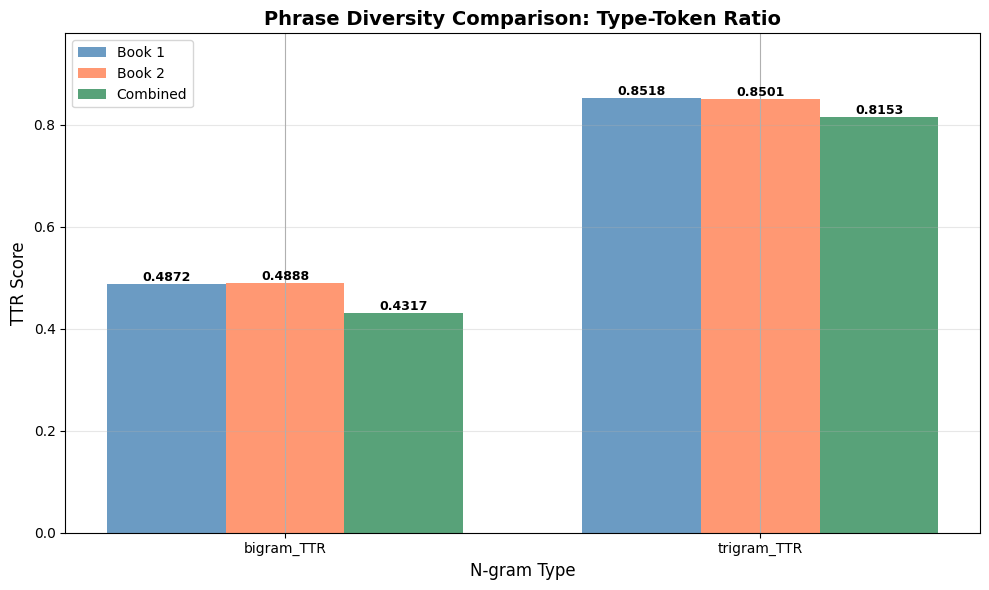

In [5]:
import numpy as np

fig_ttr, ax = plt.subplots(figsize=(10, 6))

# Set up grouped bar chart
x = np.arange(len(summary_df["metric"]))
width = 0.25

# Create bars for each book
bars1 = ax.bar(x - width, summary_df["book1"], width, label='Book 1', color='steelblue', alpha=0.8)
bars2 = ax.bar(x, summary_df["book2"], width, label='Book 2', color='coral', alpha=0.8)
bars3 = ax.bar(x + width, summary_df["combined"], width, label='Combined', color='seagreen', alpha=0.8)

# Customize plot
ax.set_ylabel("TTR Score", fontsize=12)
ax.set_xlabel("N-gram Type", fontsize=12)
ax.set_title("Phrase Diversity Comparison: Type-Token Ratio", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(summary_df["metric"])
ax.legend(fontsize=10)
ax.set_ylim(0, max(summary_df[["book1", "book2", "combined"]].max()) * 1.15)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. (Optional) Section-wise Diversity

If chapters/sections are detectable by regex, estimate diversity per section.


In [6]:
# # naive split by keywords; customize per book
# sections = re.split(r"\bchapter\b|\bbook\b|\bpart\b", full_text, flags=re.IGNORECASE)
# rows = []
# for i, sec in enumerate(sections, start=1):
#     toks = WORD_RE.findall(sec.lower())
#     b2 = list(zip(toks, toks[1:]))
#     b3 = list(zip(toks, toks[1:], toks[2:]))
#     rows.append({"section": i, "bigram_TTR": ttr(b2), "trigram_TTR": ttr(b3)})
# sec_df = pd.DataFrame(rows)

# ax = sec_df.plot(x="section", y=["bigram_TTR","trigram_TTR"])
# ax.set_title("Phrase Diversity by Section (proxy)")
# ax.set_xlabel("Section index")
# ax.set_ylabel("TTR")
# plt.tight_layout(); plt.show()

## 4. Notes

- Lower TTR suggests more formulaic phrasing (e.g., epic epithets).
- Compare the two works separately if you can split cleanly.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [7]:
Path("../results").mkdir(exist_ok=True)

summary_df.to_csv("../results/TTR_table.csv", index=False)

try:
    fig_ttr.savefig("../results/TTR_figure.png", dpi=200, bbox_inches="tight")
    print("Saved TTR_table.csv and TTR_figure.png to ../results/")
except NameError:
    print("Figure not saved – run the visualization cell first.")

Saved TTR_table.csv and TTR_figure.png to ../results/
